In [9]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import jax
import matplotlib.pyplot as plt

import src.data_generate_sde.sde_ornstein_uhlenbeck as ou
from src.data_generate_sde import sde_utils
import src.data_generate_sde.time as time
from src import plotting

In [10]:
t_start = 0.
T = 1.
x0 = (1.,)
y = (1.,)
N = 100
num_trajectories = 20
ou._SIGMA = 0.1


key =  jr.PRNGKey(1)
traj_keys = jax.random.split(key, num_trajectories)

In [11]:
ou.data_reverse_guided(x0, y, T, N)(traj_keys)



(Array([[[0.        ],
         [0.01010101],
         [0.02020202],
         ...,
         [0.97979796],
         [0.989899  ],
         [1.        ]],
 
        [[0.        ],
         [0.01010101],
         [0.02020202],
         ...,
         [0.97979796],
         [0.989899  ],
         [1.        ]],
 
        [[0.        ],
         [0.01010101],
         [0.02020202],
         ...,
         [0.97979796],
         [0.989899  ],
         [1.        ]],
 
        ...,
 
        [[0.        ],
         [0.01010101],
         [0.02020202],
         ...,
         [0.97979796],
         [0.989899  ],
         [1.        ]],
 
        [[0.        ],
         [0.01010101],
         [0.02020202],
         ...,
         [0.97979796],
         [0.989899  ],
         [1.        ]],
 
        [[0.        ],
         [0.01010101],
         [0.02020202],
         ...,
         [0.97979796],
         [0.989899  ],
         [1.        ]]], dtype=float32),
 Array([[[1.        ],
         [0.99434

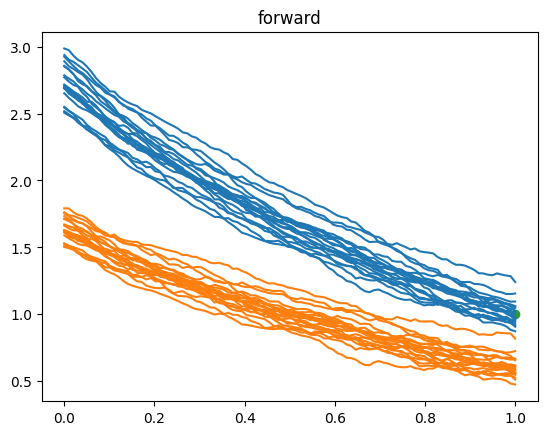

In [19]:
time_grid = time.grid(t_start=t_start, T=T ,N=N)
drift, diffusion = ou.vector_fields()

vary_x0_nonhitters = jax.random.uniform(jax.random.split(key, 2)[0], (num_trajectories, 1), minval=1.5, maxval=1.8)
# vary_x0 = jnp.concatenate([vary_x0, jnp.asarray((2.704,))[..., None]])
trajectories_none = jax.vmap(sde_utils.solution, (0, None, 0, None, None))(traj_keys, time_grid, vary_x0_nonhitters, drift, diffusion)

vary_x0 =jax.random.uniform(jax.random.split(key, 2)[0], (num_trajectories, 1), minval=2.5, maxval=3)
trajectories = jax.vmap(sde_utils.solution, (0, None, 0, None, None))(traj_keys, time_grid, vary_x0, drift, diffusion)

for traj in trajectories_none:
    plt.plot(time_grid, traj, color="C1")

for traj in trajectories:
    plt.plot(time_grid, traj, color="C0")
plt.scatter(1.0, 1.0, color="C2")
# plt.scatter(0.0, 2.704)
plt.title("forward")
plt.show()

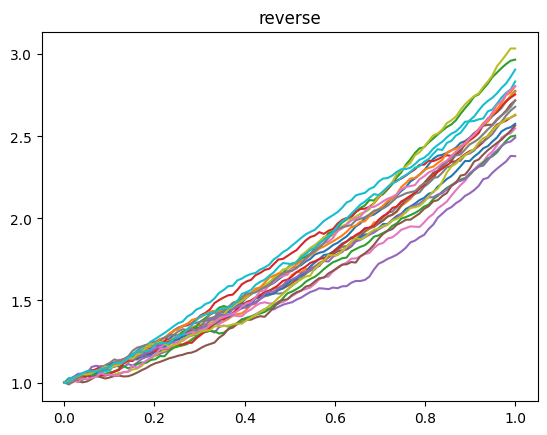

[2.776044]


In [13]:
rev_keys = jax.random.split(key, num_trajectories)
drift_rev, diffusion_rev = ou.vector_fields_reverse()
rev = jax.vmap(sde_utils.solution, (0, None, None, None, None))(traj_keys, time_grid, y, drift_rev, diffusion_rev)

for traj in rev:
    plt.plot(time_grid, traj)
plt.title("reverse")
plt.show()
print(rev[0][-1])

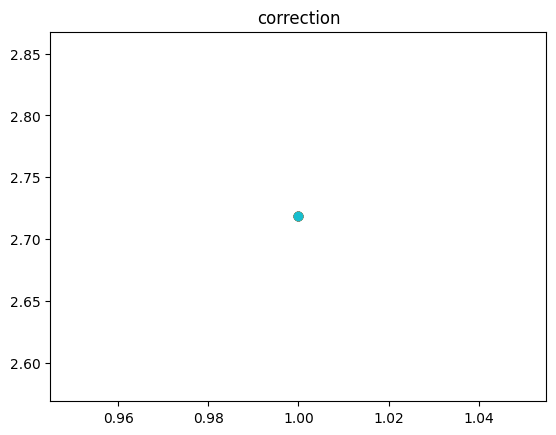

In [6]:
data_fn = ou.data_reverse(y, T, N)
ts, rev, corr = data_fn(rev_keys)

for correct in corr:
    plt.scatter(ts[0, -1], correct)
plt.title("correction")
plt.show()

In [7]:
cond_keys = jax.random.split(key, num_trajectories)
score_fn = partial(ou.score, T=T, y=jnp.asarray(y))
cond = jax.vmap(utils.conditioned, (0, None, None, None, None, None))(traj_keys, time_grid, x0, score_fn, drift, diffusion).ys

for traj in cond:
    plt.plot(time_grid, traj)
plt.title("conditioned")
plt.show()


NameError: name 'utils' is not defined

In [ ]:
# Plot trajectories made with ou.important_reverse_and_correction

keys = jax.random.split(key, num_trajectories)
trajs = (jax.vmap(utils.important_reverse_and_correction, (0, None, None, None, None, None, None))
         (keys, time_grid, x0, y, drift_rev, diffusion_rev, ou.drift_correction).ys)

print(trajs.shape)

revs = trajs[..., :-1]
corrs = trajs[..., :50 , -1]

for rev in revs:
    plt.plot(time_grid, rev)
plt.title("reverse")
plt.show()

for corr in corrs:
    plt.plot(time_grid[:50], corr)
plt.title("correction")
plt.show()

In [ ]:
def h(t, x, *args):
    assert x.ndim == 1
    zero_array = jnp.zeros(shape=(x.size,))
    return jax.lax.cond(t == T, lambda f: zero_array, lambda f: -(jnp.asarray(x0) - f) / (T - t), x)


h_y = jax.vmap(h, (0, 0))(time_grid, revs[0])


In [ ]:
plt.plot(time_grid, h_y)

In [ ]:
from src.data_generate_sde import guided_process

keys = jax.random.split(key, num_trajectories)

data_fn = ou.data_reverse_guided(x0, y, T, N)
ts, trajs, corr = data_fn(keys)

for traj in trajs:
    plt.plot(ts[0], traj)

